In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Preprocessing
### Read weather, sales, calendar and add times columns

In [2]:
import requests
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def get_calendar_data():
    # request the json file with all of the calendar events in France
    res = requests.get('https://calendrier.api.gouv.fr/jours-feries/metropole.json')

    # convert the data to a dataframe
    df = pd.DataFrame.from_dict(res.json(),orient='index')
    df.columns = ['calendar_event']

    # parse the date index
    df.index = pd.to_datetime(df.index)

    # resample by day and fill the missing values
    df = df.resample('D').first().fillna("")

    # use the label encoder to convert to numerical values. 
    le = LabelEncoder()
    le.fit(df['calendar_event'])
    df['calendar_embedding'] = le.transform(df['calendar_event'])
    
    # return also the label encoder for parsing
    return df, le

national_holidays = get_calendar_data()[0][get_calendar_data()[0]['calendar_embedding'] != 0]
national_holidays.head(4)

,calendar_event,calendar_embedding
2003-01-01,1er janvier,3
2003-04-21,Lundi de Pâques,10
2003-05-01,1er mai,4
2003-05-08,8 mai,5


In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv('/Users/zackbrodtman/Documents/cal/222/STAT222-project/data/stat_222_data/shop_1_transactions.csv', sep=';')

sns.set(style="whitegrid")

del data['price_ttc']

data['date'] = pd.to_datetime(data['date'])

items = pd.read_csv('/Users/zackbrodtman/Documents/cal/222/STAT222-project/data/stat_222_data/shop_1_items_info.csv', sep=';')

calendar = pd.read_json("/Users/zackbrodtman/Documents/cal/222/STAT222-project/data/calendar.json")

weather = pd.read_csv('/Users/zackbrodtman/Documents/cal/222/STAT222-project/data/weather_data.csv', sep=";")

weather['date'] = pd.to_datetime(weather['date'].str[:-6])
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day
weather['hour'] = weather['date'].dt.hour

In [4]:
data['year'] = data['date'].dt.year
data['year_week'] = data['date'].dt.isocalendar().week
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.day_name()

data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

data['year_week'] = data['year_week'].astype('int64')

### Remove Outliers

In [5]:
data = data[data['price_ht'] >= 0]
mask = np.abs(scipy.stats.zscore(data[['quantity']])) < 2.5
data = data[mask['quantity']]

data_f = data[~((data['year'] == 2022) & (data['year_week'] > 32)) &
              ~((data['year'] == 2018) & (data['year_week'] < 11))]

### Weekly sales

In [6]:
sales = data_f[(data_f['price_ht'] < data_f['price_ht'].quantile(0.99)) &
               (data_f['price_ht'] > data_f['price_ht'].quantile(0.01))].set_index('date').resample('W-MON').sum()

sales = pd.DataFrame(sales['price_ht'])

In [7]:
t=14
trend = sales.shift(-t).rolling(2*t+1, min_periods=1).mean()

sales_no_trend = sales - trend
sales_no_trend.dropna(inplace=True)

sales_no_trend = sales_no_trend.reset_index()
sales_no_trend['month'] = sales_no_trend['date'].dt.month

<function matplotlib.pyplot.show(close=None, block=None)>

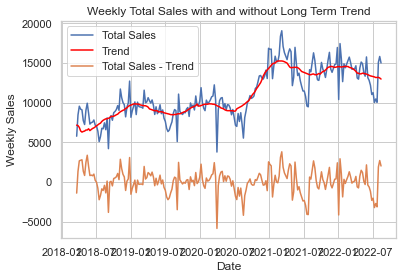

In [8]:
# with and without trend
plt.plot(sales, label = "Total Sales")
plt.plot(trend, color = 'red', label = 'Trend')
plt.plot('date', 'price_ht', data = sales_no_trend, label = 'Total Sales - Trend')
plt.xlabel("Date")
plt.ylabel('Weekly Sales')
plt.legend()
plt.title("Weekly Total Sales with and without Long Term Trend")
plt.show


## Weather and holidays

In [9]:
from datetime import timedelta, timezone

national_holidays.reset_index(inplace=True)
national_holidays['first_day_of_week'] = pd.to_datetime(national_holidays['index']\
.apply(lambda x: (x - timedelta(days=x.dayofweek))), utc=True)
national_holidays['calendar_event'] = 1

national_holidays.drop_duplicates(inplace=True)

del national_holidays['calendar_embedding']
del national_holidays['index']

In [10]:
rain = weather.set_index('date').resample('W-MON').mean()['temp'].reset_index()
rain['date'] = rain['date'].dt.tz_localize(timezone.utc)

In [11]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first').fit(sales_no_trend['month'].values.reshape(-1, 1))
months = encoder.transform(sales_no_trend['month'].values.reshape(-1, 1)).toarray()
months = pd.DataFrame(months, dtype=np.int16)
months.columns = encoder.get_feature_names_out(['Month'])

# This is an example how to get just 1 transformation
# encoder.transform(np.array([2]).reshape(-1,1)).toarray()
sales_no_trend = pd.concat([
    sales_no_trend,
    months
], axis=1)
del sales_no_trend['month']

sales_no_trend = sales_no_trend.merge(rain)
sales_no_trend = sales_no_trend.merge(national_holidays, 
                                      left_on='date',
                                      right_on='first_day_of_week',
                                      how='left').fillna(0)

#del sales_no_trend['date']
del sales_no_trend['first_day_of_week']
sales_no_trend.set_index('date', inplace=True)

sales_no_trend.drop_duplicates(inplace=True)

# Daily Total Sales LSTM

In [12]:
t=[2, 1]

daily_quantity = data_f[(data_f['quantity'] < data_f['quantity'].quantile(0.99)) &
                        (data_f['quantity'] > data_f['quantity'].quantile(0.01))].\
set_index('date').resample('D').sum()
daily_quantity = pd.DataFrame(daily_quantity['quantity'])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-09 14:46:13.152253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-09 14:46:13.153968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-09 14:46:13.530806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-09 14:46:13.534437: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2023-05-09 14:46:14.515135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:46:14.733517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:46:14.814092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:46:14.921297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/41 [=>............................] - ETA: 0s - loss: 0.1625  

2023-05-09 14:46:15.044444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 22ms/step - loss: 0.0649
Epoch 2/100
41/41 [==============================] - 1s 18ms/step - loss: 0.0411
Epoch 3/100
41/41 [==============================] - 1s 19ms/step - loss: 0.0403
Epoch 4/100
41/41 [==============================] - 1s 18ms/step - loss: 0.0390
Epoch 5/100
41/41 [==============================] - 1s 18ms/step - loss: 0.0373
Epoch 6/100
41/41 [==============================] - 1s 18ms/step - loss: 0.0329
Epoch 7/100
41/41 [==============================] - 1s 18ms/step - loss: 0.0235
Epoch 8/100
41/41 [==============================] - 1s 17ms/step - loss: 0.0201
Epoch 9/100
41/41 [==============================] - 1s 18ms/step - loss: 0.0196
Epoch 10/100
41/41 [==============================] - 1s 17ms/step - loss: 0.0188
Epoch 11/100
41/41 [==============================] - 1s 18ms/step - loss: 0.0186
Epoch 12/100
41/41 [==============================] - 1s 21ms/step - loss: 0.0183
Epoch 13/100
41/41 [=================

2023-05-09 14:47:28.373721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:47:28.438652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:47:28.485064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


RMSE: 98.39466520535402
MAPE: 20.08674052327508


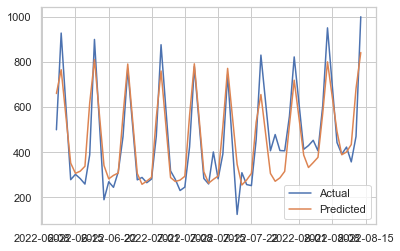

In [13]:

# Load the data
df = daily_quantity.copy()

# Remove the sales data for the closed day
df = df[df.index.dayofweek != 0]

# Split the data into training and testing sets
train_size = int(len(df) * 0.95)
train_data, test_data = df[:train_size], df[train_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Split the data into input and output
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset)-time_steps):
        X.append(dataset[i:i+time_steps])
        y.append(dataset[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 14
X_train, y_train = create_dataset(train_scaled, time_steps)
X_test, y_test = create_dataset(test_scaled, time_steps)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)
mape = MAPE(y_test, y_pred)
print('MAPE:', mape)

# Plot the results
plt.plot(df.index[train_size+time_steps:], y_test, label='Actual')
plt.plot(df.index[train_size+time_steps:], y_pred, label='Predicted')
plt.legend()
plt.show()


## Add weather and holiday data to the model

In [14]:
rain = rain.set_index('date')
national_holidays = national_holidays.set_index('first_day_of_week')

# Merge the rain data into the sales data
daily_quantity = pd.merge(daily_quantity, rain, left_index=True, right_index=True, how='left')

# Fill any missing temperature values with the average temperature for that month
daily_quantity['temp'] = daily_quantity.groupby(daily_quantity.index.month)['temp'].transform(lambda x: x.fillna(x.mean()))

# Merge the national holidays data into the sales data
daily_quantity = pd.merge(daily_quantity, national_holidays, left_index=True, right_index=True, how='left')
daily_quantity['calendar_event'].fillna(0, inplace=True)

# Fill any missing sales values with the previous day's sales value
daily_quantity['quantity'].fillna(method='ffill', inplace=True)

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


# Remove the sales data for the closed day
df = daily_quantity[daily_quantity.index.dayofweek != 0]

# Set the random seed for reproducibility
tf.random.set_seed(42)

# Split the data into training and testing sets
train_size = int(len(df) * 0.9)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[['quantity']])
test_data_scaled = scaler.transform(test_data[['quantity']])


# Create the training data set
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:(i+time_steps)])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 7
X_train, y_train = create_dataset(train_data_scaled, time_steps)
X_test, y_test = create_dataset(test_data_scaled, time_steps)

# Build the model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


mape = MAPE(y_test, y_pred)



Epoch 1/100


2023-05-09 14:47:30.299775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:47:30.485439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:47:30.540059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:47:30.611341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:47:30.695746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 0.0527

2023-05-09 14:47:31.653826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:47:31.718500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:47:31.752116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 3s 28ms/step - loss: 0.0527 - val_loss: 0.0416
Epoch 2/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0366 - val_loss: 0.0374
Epoch 3/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0309 - val_loss: 0.0284
Epoch 4/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0230 - val_loss: 0.0248
Epoch 5/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0233 - val_loss: 0.0282
Epoch 6/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0226 - val_loss: 0.0250
Epoch 7/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0190 - val_loss: 0.0317
Epoch 8/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0199 - val_loss: 0.0229
Epoch 9/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0184 - val_loss: 0.0225
Epoch 10/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0182 - val_loss: 0.0271
Epoch 11/10

2023-05-09 14:48:27.856455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:48:27.919747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-09 14:48:27.962787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## Evaluate

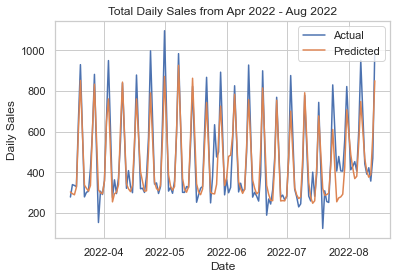

RMSE: 87.0290862519936
MAPE: 14.87%


In [16]:
# Plot the results
plt.plot(df.index[train_size+time_steps:], y_test, label='Actual')
plt.plot(df.index[train_size+time_steps:], y_pred, label='Predicted')
plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('Total Daily Sales from Apr 2022 - Aug 2022')
plt.show()

print('RMSE:', rmse)
print(f"MAPE: {mape:.2f}%")

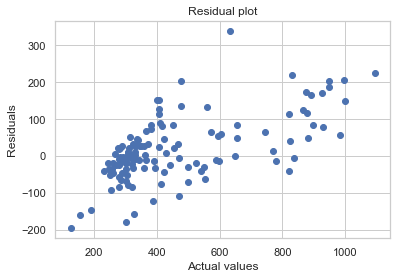

In [17]:
residuals = y_test - y_pred

plt.scatter(y_test, residuals)
plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()
